In [19]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [20]:


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs



In [21]:
def add_parens(perm):
    return '(' + ', '.join(list(perm)) + ')'


ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/experiments')
model_seed = 0
data_seed = 10
run_name = f'model_{model_seed}_data_{data_seed}'
#run_name = Path('s5_lr1e-5_5')

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(ckpt_dir / f'data_{data_seed}.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']


run_data = run_data.select(['permutation_left', 'permutation_right', 'permutation_target']).with_columns([
    pl.col('permutation_left').apply(add_parens),
    pl.col('permutation_right').apply(add_parens),
    pl.col('permutation_target').apply(add_parens),
])

In [22]:
fmodel, params = functorch.make_functional(model)

In [23]:
from copy import deepcopy

params_copy = deepcopy(params)

In [28]:
from sngrok.fourier import ift_trace

def sn_fourier_decomp(ft, group, device='cpu'):
    permutations = group.elements
    group_order = len(permutations)
    all_irreps = group.irreps()
    for k, v in all_irreps.items():
        all_irreps[k] = v.matrix_representations()
    ift_decomps = {}
    for partition, m in all_irreps.items():
        fourier_decomp = []
        for perm in permutations:
            inv_rep = torch.asarray(m[perm.sigma].T, device=device).squeeze()           
            fourier_decomp.append(ift_trace(ft[partition], inv_rep.to(torch.float32)).unsqueeze(0))
        ift_decomps[partition] = torch.cat(fourier_decomp) / group_order
            
    return ift_decomps

In [49]:
S5 = Symmetric(5)
lembed_ft = slow_sn_ft_1d(params[0], 5)
rembed_ft = slow_sn_ft_1d(params[1], 5)
unembed_ft = slow_sn_ft_1d(params[3], 5)
lembed_decomp = sn_fourier_decomp(lembed_ft, S5)
rembed_decomp = sn_fourier_decomp(rembed_ft, S5)
unembed_decomp = sn_fourier_decomp(unembed_ft, S5)

In [32]:
lembed_decomp[(2, 1, 1, 1)].shape

torch.Size([120, 256])

In [35]:
def eval_loss(model_fn, params, lperms, rperms, targets):
    logits = model_fn(params, lperms, rperms)
    return loss_fn(logits, targets).sum()



In [36]:
eval_loss(fmodel, params, lperms, rperms, targets)

tensor(0.0884, dtype=torch.float64, grad_fn=<SumBackward0>)

In [66]:
params2111 = [deepcopy(p) for p in params]


params2111[0] = lembed_decomp[(2, 1, 1, 1)]
params2111[1] = rembed_decomp[(2, 1, 1, 1)]

eval_loss(fmodel, tuple(params2111), lperms, rperms, targets)

tensor(7757.8630, dtype=torch.float64, grad_fn=<SumBackward0>)

In [65]:
params32 = [deepcopy(p) for p in params]
params32[3] = unembed_decomp[(3, 2)]
eval_loss(fmodel, tuple(params32), lperms, rperms, targets)

tensor(65261.6882, dtype=torch.float64, grad_fn=<SumBackward0>)

In [57]:
params32 = [deepcopy(p) for p in params]


params32[0] = lembed_decomp[(2, 1, 1, 1)]
params32[1] = rembed_decomp[(2, 1, 1, 1)]

eval_loss(fmodel, tuple(params32), lperms, rperms, targets) / 14400

tensor(0.5387, dtype=torch.float64, grad_fn=<DivBackward0>)

In [61]:
params_neg = [deepcopy(p) for p in params]
# this is the linear layer, multiplying the whole thing by negative 1
params_neg[2] = -1. * params[2]
print(eval_loss(fmodel, tuple(params_neg), lperms, rperms, targets))
print(eval_loss(fmodel, params, lperms, rperms, targets))

tensor(0.1876, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0884, dtype=torch.float64, grad_fn=<SumBackward0>)


In [75]:

def ablate_one_column(model_fn, params, index):
    param_copies = [deepcopy(p).detach() for p in params]
    param_copies[3][:, index] = torch.zeros((120,))
    return eval_loss(model_fn, param_copies, lperms, rperms, targets)
    

In [88]:
ablated_losses = np.zeros((128,))
for i in range(128):
    ablated_losses[i] = ablate_one_column(fmodel, params, i)


In [91]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

W = model.linear.weight

lpower_df, _ = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
rpower_df, _ = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

In [92]:
lpower_df.select(['irrep', 'dim0', 'dim1', 'dim2'])

irrep,dim0,dim1,dim2
str,f32,f32,f32
"""(1, 1, 1, 1, 1...",0.00023,0.000005,0.00052
"""(2, 1, 1, 1)""",0.037243,0.999838,0.290886
"""(2, 2, 1)""",0.942331,0.000074,0.122685
"""(3, 1, 1)""",0.007725,0.000058,0.352405
"""(3, 2)""",0.008106,0.000014,0.195374
"""(4, 1)""",0.003318,0.000009,0.037503
"""(5,)""",0.001048,0.000001,0.000626


In [109]:
df = (
    lpower_df
    .melt(id_vars='irrep')
    .sort('value')
    .groupby('variable')
    .agg([pl.col('irrep').last(), pl.col('value').max()])
    .sort('variable')
)
df

variable,irrep,value
str,str,f32
"""dim0""","""(2, 2, 1)""",0.942331
"""dim1""","""(2, 1, 1, 1)""",0.999838
"""dim10""","""(3, 2)""",0.899537
"""dim100""","""(2, 1, 1, 1)""",0.999996
"""dim101""","""(2, 1, 1, 1)""",0.6903
"""dim102""","""(4, 1)""",0.893877
"""dim103""","""(2, 1, 1, 1)""",0.999956
"""dim104""","""(2, 1, 1, 1)""",0.997918
"""dim105""","""(2, 1, 1, 1)""",0.958471


In [110]:
ablation_df = pl.DataFrame({'ablation_loss': ablated_losses, 'dim': [f'dim{i}' for i in range(128)]})
ablation_df = ablation_df.join(df, left_on='dim', right_on='variable', how='inner')

In [111]:
ablation_df

ablation_loss,dim,irrep,value
f64,str,str,f32
0.095213,"""dim0""","""(2, 2, 1)""",0.942331
44.164559,"""dim1""","""(2, 1, 1, 1)""",0.999838
0.089468,"""dim10""","""(3, 2)""",0.899537
311.308014,"""dim100""","""(2, 1, 1, 1)""",0.999996
0.088358,"""dim101""","""(2, 1, 1, 1)""",0.6903
0.093144,"""dim102""","""(4, 1)""",0.893877
8.752068,"""dim103""","""(2, 1, 1, 1)""",0.999956
0.334863,"""dim104""","""(2, 1, 1, 1)""",0.997918
0.088767,"""dim105""","""(2, 1, 1, 1)""",0.958471


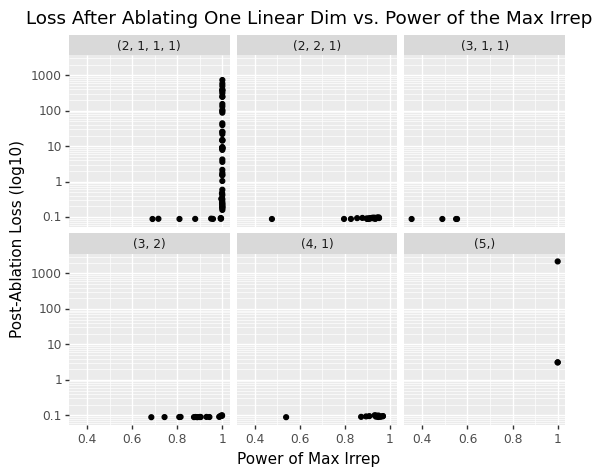

<ggplot: (773544291)>

In [116]:
from plotnine import scale_y_log10

(
    ggplot(
        ablation_df,
        aes(x = 'value', y='ablation_loss')
    ) 
    + geom_point() 
    + facet_wrap('~irrep') 
    + scale_y_log10()
    + xlab('Power of Max Irrep')
    + ylab('Post-Ablation Loss (log10)')
    + ggtitle('Loss After Ablating One Linear Dim vs. Power of the Max Irrep')
)

In [125]:
from torch.nn.functional import relu




tensor([0.4812, 2.5575, 0.0498, 0.4936, 0.0382, 0.3085, 2.1559, 1.7670, 3.1559,
        0.2206, 0.2067, 0.2913, 1.8553, 3.3694, 0.2118, 0.3923, 0.4318, 3.2536,
        2.8052, 3.1725, 2.0217, 0.1813, 1.3201, 0.1163, 2.7131, 0.5623, 0.1660,
        1.5112, 0.1962, 2.7400, 0.4894, 0.2726, 0.0636, 0.5145, 0.4629, 2.1122,
        2.1739, 1.9512, 0.4747, 1.7497, 0.5445, 2.9931, 2.1876, 0.3696, 0.2208,
        0.3818, 1.3088, 0.2542, 2.1189, 0.2414, 0.3592, 3.3327, 1.4136, 0.6727,
        0.3616, 1.4134, 0.3620, 0.1213, 0.4011, 0.0892, 0.1073, 0.2226, 3.5111,
        1.5346, 0.1342, 0.1114, 0.4570, 0.4791, 2.2091, 0.4217, 2.7376, 2.5002,
        2.0597, 1.8745, 0.2483, 1.8743, 1.3405, 2.8368, 2.6987, 0.4367, 0.5921,
        0.5033, 0.5830, 0.4878, 3.2235, 1.7455, 0.2262, 0.4057, 0.3066, 0.5130,
        3.0339, 2.3888, 0.4099, 1.6435, 0.4873, 0.5399, 2.0430, 3.3002, 0.3515,
        0.5113, 3.2679, 0.0917, 0.3980, 2.1154, 1.2378, 0.2539, 0.4159, 1.6673,
        0.3489, 2.0678, 2.9959, 0.2893, 

In [130]:
act_means = relu(linear_acts).mean(dim=0)
acts = deepcopy(linear_acts)

In [132]:
acts[:, 0] = act_means[0]

In [133]:
acts[:, 0]

tensor([0.4812, 0.4812, 0.4812,  ..., 0.4812, 0.4812, 0.4812])

In [149]:
def mean_ablate_one_column(model, linear_activations, index):
    
    act_means = relu(linear_activations).mean(0)
    
    acts = deepcopy(relu(linear_activations))
    acts[:, index] = act_means[index]
    
    logits = model.unembed(acts)
    
    return loss_fn(logits, targets).sum()
    

In [150]:
mean_ablations = torch.zeros((128,))
for i in range(128):   
    mean_ablations[i] = mean_ablate_one_column(model, linear_acts, i)

    

In [151]:
loss_fn(model.unembed(linear_acts), targets).sum()

tensor(88411.2850, dtype=torch.float64, grad_fn=<SumBackward0>)

In [153]:
ablation_df.insert_at_idx(0, pl.Series('mean_ablation_loss', mean_ablations.detach().numpy()))
ablation_df = ablation_df.rename({'ablation_loss': 'zero_ablation_loss'})

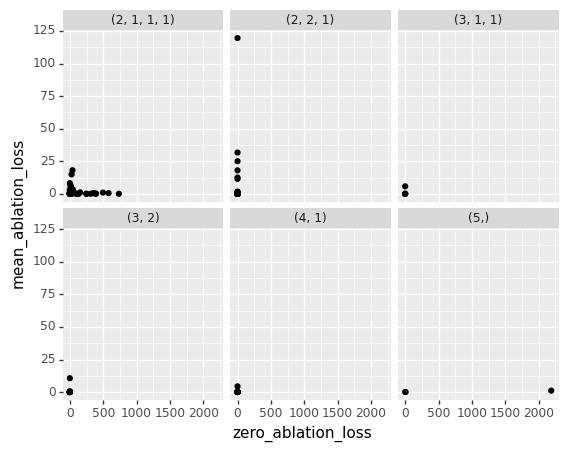

<ggplot: (685664088)>

In [155]:
ggplot(ablation_df, aes(x = 'zero_ablation_loss', y = 'mean_ablation_loss')) + geom_point() + facet_wrap('~irrep')

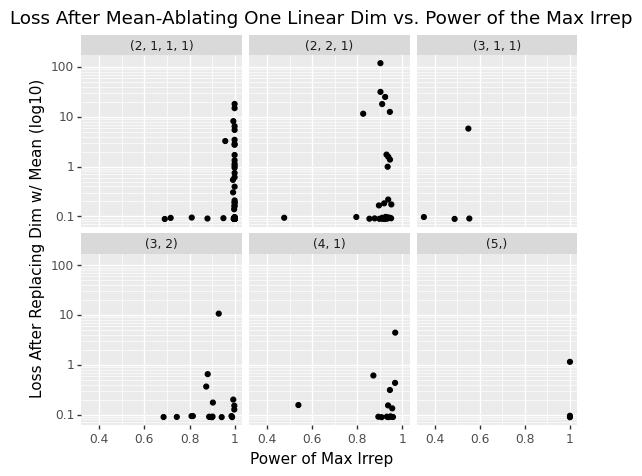

<ggplot: (688753322)>

In [156]:
(
    ggplot(
        ablation_df,
        aes(x = 'value', y='mean_ablation_loss')
    ) 
    + geom_point() 
    + facet_wrap('~irrep') 
    + scale_y_log10()
    + xlab('Power of Max Irrep')
    + ylab('Loss After Replacing Dim w/ Mean (log10)')
    + ggtitle('Loss After Mean-Ablating One Linear Dim vs. Power of the Max Irrep')
)